In [1]:
import numpy as np
import cv2 as cv

from PIL import Image
import sys
import os
import urllib
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time




%matplotlib inline

In [2]:

# https://github.com/yeephycho/tensorflow-face-detection
FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'
#FROZEN_GRAPH_NAME = 'data/facessd_mobilenet_v2_quantized_320x320_open_image_v4/tflite_graph.pb'

#!wget https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true -O {FROZEN_GRAPH_NAME}

In [3]:

# go warriors!
IMAGE_PATH = 'data/warriors.jpg'
!wget 'https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg' -O {IMAGE_PATH}

--2020-02-25 20:00:01--  https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg
Resolving cdn.vox-cdn.com (cdn.vox-cdn.com)... 151.101.148.124
Connecting to cdn.vox-cdn.com (cdn.vox-cdn.com)|151.101.148.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116503 (114K) [image/jpeg]
Saving to: ‘data/warriors.jpg’

data/warriors.jpg   100%[===================>] 113.77K  --.-KB/s    in 0.06s   

2020-02-25 20:00:16 (1.90 MB/s) - ‘data/warriors.jpg’ saved [116503/116503]



In [4]:
output_dir=''
frozen_graph = tf.compat.v1.GraphDef()  
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
  frozen_graph.ParseFromString(f.read())

In [5]:
# https://github.com/NVIDIA-AI-IOT/tf_trt_models/blob/master/tf_trt_models/detection.py
INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'

input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

In [7]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Running against TensorRT version 6.0.1


In [8]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

# use this if you want to try on the optimized TensorRT graph
# Note that this will take a while
# tf.import_graph_def(trt_graph, name='')

# use this if you want to try directly on the frozen TF graph
# this is much faster
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

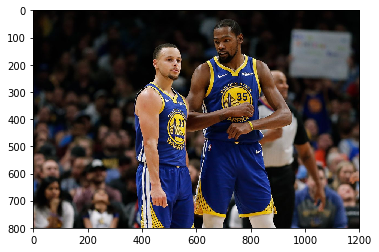

In [9]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

In [10]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

In [11]:
# suppress boxes that are below the threshold.. 
DETECTION_THRESHOLD = 0.5

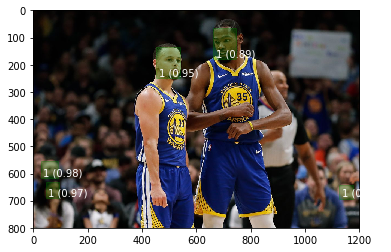

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    if scores[i] < DETECTION_THRESHOLD:
        continue
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

In [13]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.087507 seconds


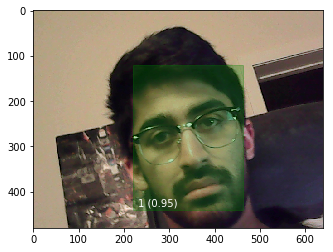

In [29]:
def capture_faces(image):
    
#    image_resized = np.array(image.resize((300, 300)))
    image_resized = cv.resize(image, (300,300), interpolation = cv.INTER_AREA)
    image = np.array(image)
    
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })

    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.imshow(image)

    # plot boxes exceeding score threshold
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)

        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

    plt.show()

cap = cv.VideoCapture(1)    

ret, frame = cap.read()
frame_fix = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

capture_faces(frame_fix)

cap.release()

In [30]:
cap.release()

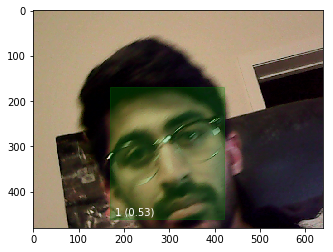

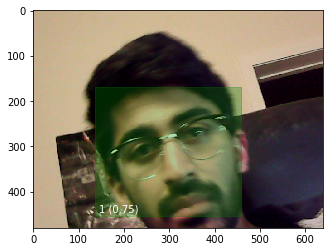

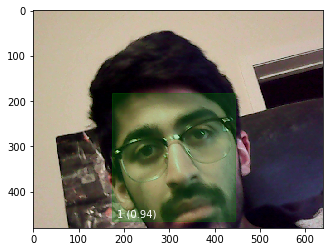

In [33]:
cap = cv.VideoCapture(1, cv.CAP_V4L)


#while(True):
for x in range(3):
    ret, frame = cap.read()
    frame_fix = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    capture_faces(frame_fix)

cap.release()

In [ ]:
tf_sess.close()